In [1]:
import os
import tqdm
import sys, re
import numpy as np
import pandas as pd
from bunch import Bunch
import _pickle as pickle
from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score,\
    roc_auc_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier

import tensorflow as tf
from keras import metrics
from keras import optimizers
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import keras.backend.tensorflow_backend as KTF

Using TensorFlow backend.


In [2]:
seed = 142
pd.options.display.max_columns = 50
np.random.seed(seed)

## Read data

In [3]:
data = pd.read_feather('Xy_norm.feather')

In [4]:
data.shape

(245455, 42)

In [5]:
data.head(3)

,orders_num,is_failed_num,voucher_amount_sum,delivery_fee_mean,delivery_fee_sum,restaurant_id_unq_num,city_id_unq_num,payment_id_unq_num,platform_id_unq_num,transmission_id_unq_num,amount_paid_mean,amount_paid_std,payment_id_1491_num,payment_id_1523_num,payment_id_1619_num,payment_id_1779_num,payment_id_1811_num,platform_id_525_num,platform_id_22167_num,platform_id_22263_num,platform_id_22295_num,platform_id_29463_num,platform_id_29495_num,platform_id_29751_num,platform_id_29815_num,platform_id_30135_num,platform_id_30199_num,platform_id_30231_num,platform_id_30359_num,platform_id_30391_num,platform_id_30423_num,transmission_id_212_num,transmission_id_1988_num,transmission_id_2020_num,transmission_id_4196_num,transmission_id_4228_num,transmission_id_4260_num,transmission_id_4324_num,transmission_id_4356_num,transmission_id_4996_num,transmission_id_21124_num,is_returning_customer
0,-0.313796,-0.153931,-0.160605,-0.534689,-0.248892,-0.412621,-0.170542,-0.3857,-0.407176,-0.515242,0.114188,-0.462233,-0.096045,-0.026364,-0.417414,0.012129,-0.109599,-0.061359,-0.003496,-0.012939,-0.002018,-0.259836,-0.121011,-0.064448,-0.193848,-0.010699,-0.02617,0.029065,-0.256269,-0.172863,-0.105601,-0.095907,-0.025389,-0.002018,-0.067011,-0.295478,-0.114311,-0.330953,-0.100007,-0.103457,-0.021054,0
1,-0.313796,-0.153931,-0.160605,-0.534689,-0.248892,-0.412621,-0.170542,-0.3857,-0.407176,-0.515242,-0.215465,-0.462233,-0.096045,-0.026364,-0.202441,-0.250828,-0.109599,-0.061359,-0.003496,-0.012939,-0.002018,-0.259836,-0.121011,-0.064448,-0.193848,-0.010699,-0.02617,-0.219259,0.350588,-0.172863,-0.105601,-0.095907,-0.025389,-0.002018,-0.067011,-0.295478,-0.114311,-0.330953,-0.100007,-0.103457,-0.021054,0
2,-0.313796,-0.153931,-0.160605,0.864187,-0.037560,-0.412621,-0.170542,-0.3857,-0.407176,-0.515242,-0.839974,-0.462233,-0.096045,-0.026364,-0.202441,-0.250828,-0.109599,-0.061359,-0.003496,-0.012939,-0.002018,-0.259836,-0.121011,-0.064448,-0.193848,-0.010699,-0.02617,-0.219259,0.350588,-0.172863,-0.105601,-0.095907,-0.025389,-0.002018,-0.067011,-0.295478,-0.114311,0.067902,-0.354967,-0.103457,-0.021054,1


In [6]:
X = data.iloc[:, 1:-1]
y = data.iloc[:, -1]

In [7]:
# Create train, val, test matrices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, 
                                                    shuffle=True, random_state=seed) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.1, stratify=y_test, 
                                                shuffle=True, random_state=seed) 

In [8]:
# Check if splitting has the same ratio of positive labels
y_train.mean(), y_val.mean(), y_test.mean(), len(y_train), len(y_val), len(y_test)

(0.22614045094227614,
 0.22614035881882516,
 0.22609994568169473,
 171818,
 66273,
 7364)

$Comment$: Distribution of labels is the same for train, validation and test sets.

## Create metric functions

In [9]:
# Compute metrics: accuracy, auc, aps, precision, recall, f1
def compute_metrics(y_true, y_pred, prob):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, prob)
    aps = average_precision_score(y_true, prob)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {'acc': acc, 'auc': auc, 'aps': aps, 
            'precision': precision, 'recall': recall, 
            'f1': f1}


# Compute basic metrics: accuracy, auc, aps (used for zero baseline mainly)
def compute_basic_metrics(y_true, y_pred, prob):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, prob)
    aps = average_precision_score(y_true, prob)
    
    return {'acc': acc, 'auc': auc, 'aps': aps}


# Compute accuracy for different thresholds [0.1, ..., 0.9]
def try_acc_thresholds(model, data_dict):
    thresholds = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
    for thr in thresholds:
        acc_train = accuracy_score(data_dict['y_train'], 
                                   (model.predict_proba(data_dict['X_train'])[:,1] > thr).astype('int'))
        acc_val = accuracy_score(data_dict['y_val'], 
                                 (model.predict_proba(data_dict['X_val'])[:,1] > thr).astype('int'))
        print('Threshold= {}, Train acc= {:.3f},  Val acc= {:.3f}'.format(thr, acc_train, acc_val))
        
        
# Compute basic metrics for zero output 
def compute_zero_baseline(y_true):
    metric_dict = compute_basic_metrics(y_true, np.zeros(y_true.shape[0]), np.zeros(y_true.shape[0]))
    return metric_dict


# Compute metrics for random 0/1 output 
def compute_rand_baseline(y_true, thr=0.5):
    rand_pred = np.random.random_sample((y_true.shape[0],))
    metric_dict = compute_metrics(y_true, np.round(rand_pred + 0.5 - thr), rand_pred)
    return metric_dict

## Baseline

### Train set

In [10]:
# Zero baseline
compute_zero_baseline(y_train)

{'acc': 0.77385954905772392, 'auc': 0.5, 'aps': 0.22614045094227614}

In [11]:
# Random baseline (threshold=0.5)
compute_rand_baseline(y_train, thr=0.5)

{'acc': 0.50166455202598093,
 'auc': 0.49902688741915818,
 'aps': 0.22540208355054861,
 'precision': 0.22651571856287425,
 'recall': 0.49846866555140906,
 'f1': 0.3114852966009698}

In [12]:
# Random baseline (threshold=0.5)
compute_rand_baseline(y_train, thr=0.9)

{'acc': 0.71883621040868828,
 'auc': 0.49983634918525133,
 'aps': 0.22591723023333327,
 'precision': 0.2247262986256697,
 'recall': 0.09931797709432505,
 'f1': 0.13775501097685044}

### Validation set

In [13]:
# Zero baseline
compute_zero_baseline(y_val)

{'acc': 0.77385964118117478, 'auc': 0.5, 'aps': 0.22614035881882516}

In [14]:
# Random baseline (threshold=0.5)
compute_rand_baseline(y_val, thr=0.5)

{'acc': 0.49979629713457968,
 'auc': 0.49895146944039614,
 'aps': 0.22480537945599074,
 'precision': 0.22617216945575155,
 'recall': 0.5005004337092146,
 'f1': 0.31155507559395246}

In [15]:
# Random baseline (threshold=0.9)
compute_rand_baseline(y_val, thr=0.9)

{'acc': 0.71950869886680846,
 'auc': 0.49780329578931493,
 'aps': 0.22545030671614247,
 'precision': 0.2266241651487553,
 'recall': 0.099619670380996866,
 'f1': 0.13840092699884124}

$Comment$: We will compare these zero and random baselines metrics with the models below.

## Logistic regression

In [16]:
# Train with regularization
log_reg = LogisticRegression(C=1.0)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
# Predict for val set
y_pred_val = log_reg.predict_proba(X_val)[:,1]

In [18]:
# See the coefficients
log_reg.coef_, log_reg.intercept_

(array([[-0.12285088, -0.01030362, -0.00572957, -0.02866086,  0.03796215,
          0.01761493,  0.0884019 ,  0.13637196,  0.20661698, -0.13702989,
          0.23212244, -0.04069597,  0.04032924,  0.14646664,  0.20079719,
          0.04427254, -0.05777088, -0.00105366, -0.01519414,  0.00268847,
          0.09233123,  0.01914287,  0.06276501,  0.11505164, -0.00090941,
         -0.00617146,  0.10355623,  0.19911338, -0.16014418,  0.02205983,
          0.02016334,  0.04578503,  0.01298719, -0.01535417,  0.16437958,
          0.00608195,  0.04054943,  0.21664891,  0.18991323, -0.00990552]]),
 array([-1.3319579]))

In [19]:
# Collect the outputs and labels
prob_train = log_reg.predict_proba(X_train)[:,1]
y_pred_train = log_reg.predict(X_train)
prob_val = log_reg.predict_proba(X_val)[:,1]
y_pred_val = log_reg.predict(X_val)

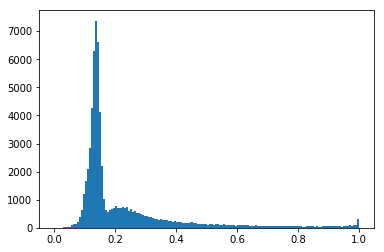

In [20]:
# Check the output distribution (val set)
plt.hist(prob_val, bins=150)
plt.show()

In [21]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.80887334272311395,
 'auc': 0.75145655928212052,
 'aps': 0.54329449453961198,
 'precision': 0.70923761825264331,
 'recall': 0.26241153004761292,
 'f1': 0.38308504442899816}

In [22]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.80773467324551473,
 'auc': 0.75378287981653935,
 'aps': 0.5432914675130337,
 'precision': 0.70005346640527533,
 'recall': 0.26209381463935411,
 'f1': 0.38139625206330713}

In [23]:
# Try thresholds on train set
data_dict = {'X_train': X_train, 'y_train': y_train,
             'X_val': X_val, 'y_val': y_val}
try_acc_thresholds(log_reg, data_dict)

Threshold= 0.1, Train acc= 0.260,  Val acc= 0.260
Threshold= 0.2, Train acc= 0.737,  Val acc= 0.736
Threshold= 0.3, Train acc= 0.794,  Val acc= 0.793
Threshold= 0.4, Train acc= 0.808,  Val acc= 0.807
Threshold= 0.5, Train acc= 0.809,  Val acc= 0.808
Threshold= 0.6, Train acc= 0.805,  Val acc= 0.804
Threshold= 0.7, Train acc= 0.799,  Val acc= 0.799
Threshold= 0.8, Train acc= 0.794,  Val acc= 0.794
Threshold= 0.9, Train acc= 0.788,  Val acc= 0.787


$Comment$: No overfitting as metrics on the validation set are not worse than on the train set.

Threshold 0.5 should work fine to be picked as it gives the best accuracy on both train and val sets.

The model performs better than zero and random baselines.

## Random forest

### Relatevily small model

In [24]:
# Train
tree_clf = RandomForestClassifier(n_estimators=50, max_depth=4)
tree_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
# Collect the outputs and labels
prob_train = tree_clf.predict_proba(X_train)[:,1]
y_pred_train = tree_clf.predict(X_train)
prob_val = tree_clf.predict_proba(X_val)[:,1]
y_pred_val = tree_clf.predict(X_val)

In [26]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.80716222980130137,
 'auc': 0.75868446728275896,
 'aps': 0.5386024973431971,
 'precision': 0.69934503901895206,
 'recall': 0.25831939261356324,
 'f1': 0.37728118480651041}

In [27]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.80651245605299293,
 'auc': 0.75973274772595301,
 'aps': 0.53824588660841943,
 'precision': 0.69397633560415917,
 'recall': 0.25829051844932277,
 'f1': 0.37646486749331387}

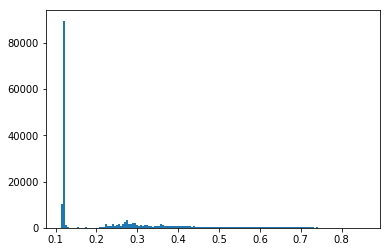

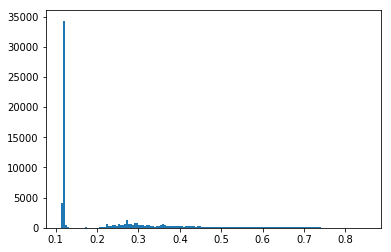

In [28]:
# Check the output distribution (val set)
plt.hist(prob_train, bins=150)
plt.show()
plt.hist(prob_val, bins=150)
plt.show()

In [29]:
# Try thresholds on train set
try_acc_thresholds(tree_clf, data_dict)

Threshold= 0.1, Train acc= 0.226,  Val acc= 0.226
Threshold= 0.2, Train acc= 0.695,  Val acc= 0.694
Threshold= 0.3, Train acc= 0.775,  Val acc= 0.775
Threshold= 0.4, Train acc= 0.806,  Val acc= 0.805
Threshold= 0.5, Train acc= 0.807,  Val acc= 0.807
Threshold= 0.6, Train acc= 0.798,  Val acc= 0.798
Threshold= 0.7, Train acc= 0.784,  Val acc= 0.784
Threshold= 0.8, Train acc= 0.775,  Val acc= 0.775
Threshold= 0.9, Train acc= 0.774,  Val acc= 0.774


### Bigger model

In [30]:
# Train bigger model
tree_clf_2 = RandomForestClassifier(n_estimators=50, max_depth=50)
tree_clf_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
# Collect the outputs and labels
prob_train = tree_clf_2.predict_proba(X_train)[:,1]
y_pred_train = tree_clf_2.predict(X_train)
prob_val = tree_clf_2.predict_proba(X_val)[:,1]
y_pred_val = tree_clf_2.predict(X_val)

In [32]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.95863064405359155,
 'auc': 0.97249366382015756,
 'aps': 0.94884924779414237,
 'precision': 0.99096842040147226,
 'recall': 0.82457856131771978,
 'f1': 0.90014890568370187}

In [33]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.78614216951096227,
 'auc': 0.73220959172038191,
 'aps': 0.48878494075789947,
 'precision': 0.53990196078431374,
 'recall': 0.36745179155267899,
 'f1': 0.43728907769881287}

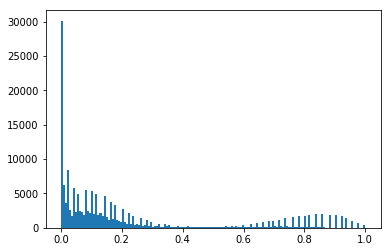

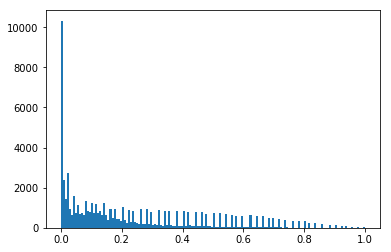

In [34]:
# Check the output distribution (train, val)
plt.hist(prob_train, bins=150)
plt.show()
plt.hist(prob_val, bins=150)
plt.show()

$Comment:$ No overfitting even with the second model. But making the model much much bigger brings overfitting on some metrics on validation set. 

The second model is bigger, but performance is not significantly better than on the first model.

Threshold of 0.5 works fine again, as for the logistic regression.

Some metrics are better, some are worse on the validation set comparing two models - logistic regression and random forest. Overall, the performance is about the same.

## Decision tree

### Default configuration

In [35]:
# Train 
dtree_clf = tree.DecisionTreeClassifier()
dtree_clf = dtree_clf.fit(X_train, y_train)

In [36]:
# Collect the outputs and labels
prob_train = dtree_clf.predict_proba(X_train)[:,1]
y_pred_train = dtree_clf.predict(X_train)
prob_val = dtree_clf.predict_proba(X_val)[:,1]
y_pred_val = dtree_clf.predict(X_val)

In [37]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.96072588436601525,
 'auc': 0.9886546668212034,
 'aps': 0.96903076615064454,
 'precision': 0.99644370226056844,
 'recall': 0.82928837987389015,
 'f1': 0.90521406899651646}

In [38]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.74989814856728987,
 'auc': 0.59166806763472457,
 'aps': 0.32123279781139058,
 'precision': 0.43966565349544073,
 'recall': 0.3860679255354641,
 'f1': 0.4111272959818098}

In [39]:
# Check params
dtree_clf.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

$Comment:$ Let's try to avoid overfitting.

### Smaller model

In [40]:
# Train smaller model
dtree_clf = tree.DecisionTreeClassifier(max_depth=6)
dtree_clf = dtree_clf.fit(X_train, y_train)

In [41]:
# Collect the outputs and labels
prob_train = dtree_clf.predict_proba(X_train)[:,1]
y_pred_train = dtree_clf.predict(X_train)
prob_val = dtree_clf.predict_proba(X_val)[:,1]
y_pred_val = dtree_clf.predict(X_val)

In [42]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.80973471929599927,
 'auc': 0.75395425531900395,
 'aps': 0.51806586081193828,
 'precision': 0.6988643695960769,
 'recall': 0.27875434307038993,
 'f1': 0.3985428587198499}

In [43]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.80842877189805806,
 'auc': 0.75307639588258024,
 'aps': 0.51301098967475145,
 'precision': 0.68937014382542572,
 'recall': 0.2782411423233469,
 'f1': 0.3964632059326868}

$Comment:$ The second model is better than the first one probably as we got rid of overfitting.

The accuracy and f1 score are slightly better than on the previous models, but still almost the same. And better than on the baseline anyway.

## XGboost

In [44]:
# Train
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
# Collect the outputs and labels
prob_train = xgb_model.predict_proba(X_train)[:,1]
y_pred_train = xgb_model.predict(X_train)
prob_val = xgb_model.predict_proba(X_val)[:,1]
y_pred_val = xgb_model.predict(X_val)

In [46]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.81517070388434276,
 'auc': 0.7682560859757479,
 'aps': 0.56756526025567378,
 'precision': 0.69074492099322804,
 'recall': 0.33076824089563761,
 'f1': 0.44732949304745834}

In [47]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.81312148235329618,
 'auc': 0.76819135371962366,
 'aps': 0.5618083925431453,
 'precision': 0.67802408319649698,
 'recall': 0.33061987055448055,
 'f1': 0.44449428122897511}

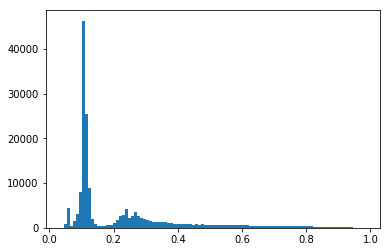

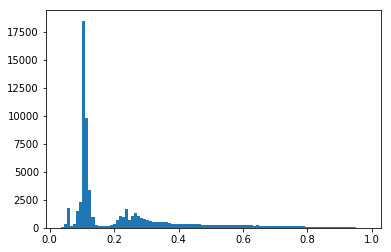

In [48]:
# Check the output distribution (train, val)
plt.hist(xgb_model.predict_proba(X_train)[:,1], bins=100)
plt.show()
plt.hist(xgb_model.predict_proba(X_val)[:,1], bins=100)
plt.show()

In [49]:
# Try thresholds on train set
try_acc_thresholds(xgb_model, data_dict)

Threshold= 0.1, Train acc= 0.301,  Val acc= 0.302
Threshold= 0.2, Train acc= 0.706,  Val acc= 0.705
Threshold= 0.3, Train acc= 0.788,  Val acc= 0.787
Threshold= 0.4, Train acc= 0.811,  Val acc= 0.809
Threshold= 0.5, Train acc= 0.815,  Val acc= 0.813
Threshold= 0.6, Train acc= 0.810,  Val acc= 0.809
Threshold= 0.7, Train acc= 0.800,  Val acc= 0.799
Threshold= 0.8, Train acc= 0.788,  Val acc= 0.788
Threshold= 0.9, Train acc= 0.778,  Val acc= 0.777


$Comment:$ The best model so far regarding the val set. 

No overfitting as the metrics on train and val sets are similar. 

Threshold to be picked is 0.5 again.

## SVM with kernel rbf

In [50]:
# # Vary gamma and print metrics after each run
# gamma = 1
# for i in range(3):
#     svm_clf = svm.SVC(kernel='rbf', gamma=gamma, probability=True)
#     svm_clf.fit(X_train, y_train)
    
#     prob_train = svm_clf.predict_proba(X_train)[:,1]
#     y_pred_train = svm_clf.predict(X_train)
#     prob_val = svm_clf.predict_proba(X_val)[:,1]
#     y_pred_val = svm_clf.predict(X_val)

#     scores_train = compute_metrics(y_train, y_pred_train, prob_train)
#     scores_val = compute_metrics(y_val, y_pred_val, prob_val)
#     print('Gamma= {}\nTrain scores:\n{},\nVal scores:\n{}'.format(gamma, scores_train, scores_val))
#     gamma /= 10 

$Comment:$ Takes too time to learn a single model because of the rbf kernel. I'm too lazy to wait.

# Ensemble

In [51]:
# Models: log reg, decision tree, gxboost 
class EnsembleModel():
    def __init__(self, model_list, weights=None):
        self.model_list = model_list
        if not weights:
            self.weights = [1./len(model_list)] * len(model_list)
        else:
            self.weights = weights
        # check sum of weight =1
        if sum(self.weights) != 1.:
            print('Error. Weights sum is not 1')
    
    def predict_proba(self, X):
        outputs = np.vstack([model.predict_proba(X)[:,1] for model in self.model_list])
        return np.average(outputs, axis=0, weights=self.weights)
    
    def predict(self, X):
        outputs = np.vstack([model.predict(X) for model in self.model_list])
        return np.round(np.average(outputs, axis=0, weights=self.weights))

In [52]:
# Train with regularization
log_reg = LogisticRegression(C=1.0)
log_reg.fit(X_train, y_train)

dtree_clf = tree.DecisionTreeClassifier(max_depth=6)
dtree_clf = dtree_clf.fit(X_train, y_train)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

ensemble = EnsembleModel([log_reg, dtree_clf, xgb_model])#, weights=[0.1, 0.3, 0.6])

In [53]:
# Collect the outputs and labels
prob_train = ensemble.predict_proba(X_train)
y_pred_train = ensemble.predict(X_train)
prob_val = ensemble.predict_proba(X_val)
y_pred_val = ensemble.predict(X_val)

In [54]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.81396594070469919,
 'auc': 0.76583364354461059,
 'aps': 0.56351436398000676,
 'precision': 0.7111860251302482,
 'recall': 0.29862308583193925,
 'f1': 0.42062715243791915}

In [55]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.81242738370075296,
 'auc': 0.76695420735381781,
 'aps': 0.56070747510415653,
 'precision': 0.70018796992481203,
 'recall': 0.298258490691933,
 'f1': 0.41832389686958965}

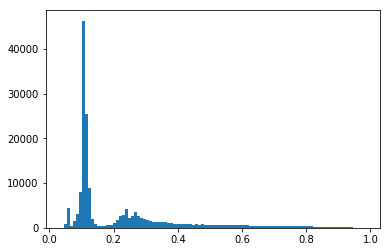

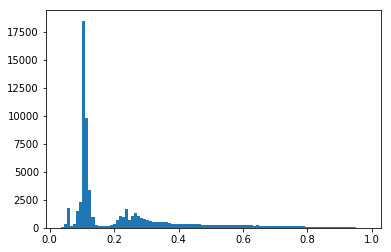

In [56]:
# Check the output distribution (train, val)
plt.hist(xgb_model.predict_proba(X_train)[:,1], bins=100)
plt.show()
plt.hist(xgb_model.predict_proba(X_val)[:,1], bins=100)
plt.show()

$Comment:$ No overfitting. Output predictions distribution is as expected (like in other models).

Metrics are about the same, but precision score is higher than for all of the previous models.

# MLP in Keras

In [57]:
# Set GPU usage with fraction
def get_session(gpu_fraction=0.2):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())

In [58]:
# Create model
model = Sequential()
model.add(Dense(128, input_dim=40, kernel_initializer='uniform', activation='relu'))
model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# Optimizer
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=callbacks_list, 
          verbose=2, validation_data=(X_val, y_val))

Train on 171818 samples, validate on 66273 samples
Epoch 1/50
 - 9s - loss: 0.4571 - acc: 0.8060 - val_loss: 0.4433 - val_acc: 0.8119

Epoch 00001: val_acc improved from -inf to 0.81193, saving model to weights.best.hdf5
Epoch 2/50
 - 9s - loss: 0.4424 - acc: 0.8128 - val_loss: 0.4426 - val_acc: 0.8124

Epoch 00002: val_acc improved from 0.81193 to 0.81238, saving model to weights.best.hdf5
Epoch 3/50
 - 9s - loss: 0.4410 - acc: 0.8128 - val_loss: 0.4400 - val_acc: 0.8121

Epoch 00003: val_acc did not improve from 0.81238
Epoch 4/50
 - 9s - loss: 0.4403 - acc: 0.8135 - val_loss: 0.4398 - val_acc: 0.8119

Epoch 00004: val_acc did not improve from 0.81238
Epoch 5/50
 - 9s - loss: 0.4398 - acc: 0.8132 - val_loss: 0.4412 - val_acc: 0.8127

Epoch 00005: val_acc improved from 0.81238 to 0.81265, saving model to weights.best.hdf5
Epoch 6/50
 - 9s - loss: 0.4394 - acc: 0.8136 - val_loss: 0.4413 - val_acc: 0.8110

Epoch 00006: val_acc did not improve from 0.81265
Epoch 7/50
 - 9s - loss: 0.4389

In [59]:
# Restore the best epoch
model.load_weights("weights.best.hdf5")

In [60]:
# Estimate loss and accuracy using loaded weights
scores_train = model.evaluate(X_train, y_train, verbose=0)
scores_val = model.evaluate(X_val, y_val, verbose=0)
scores_train, scores_val

([0.43481558462942616, 0.8164453084063461],
 [0.4388669556738351, 0.81386084830926619])

In [61]:
# Calculate predictions
prob_train = model.predict(X_train)
y_pred_train = [round(x[0]) for x in prob_train]
prob_val = model.predict(X_val)
y_pred_val = [round(x[0]) for x in prob_val]

In [62]:
# Train set metrics
compute_metrics(y_train, y_pred_train, prob_train)

{'acc': 0.81644530840773377,
 'auc': 0.77047796193962204,
 'aps': 0.57438406346180459,
 'precision': 0.69189614476789929,
 'recall': 0.33949298674559258,
 'f1': 0.45549033149171264}

In [63]:
# Val set metrics
compute_metrics(y_val, y_pred_val, prob_val)

{'acc': 0.81386084830926619,
 'auc': 0.76791903370941617,
 'aps': 0.56157294653149858,
 'precision': 0.67609937558124089,
 'recall': 0.33956095282578236,
 'f1': 0.45207426490183883}

$Comment:$ The metrics are good, precision score is slightly higher than in XGBoost model (but lower than in Ensemble model), other metrics are as good as on XGB or on Ensemble. 

Tried different learning rate (lower), the result is about the same.

# Sequences in tensorflow

### Read data

In [64]:
order_data_lbl = pd.read_feather('order_data_lbl.feather')
labeled_data = pd.read_csv('machine_learning_challenge_labeled_data.csv')

In [65]:
order_data_lbl.shape, labeled_data.shape

((786600, 36), (245455, 2))

In [66]:
order_data_lbl.head(3)

,customer_id,order_hour,is_failed,voucher_amount,delivery_fee,amount_paid,payment_id_1491,payment_id_1523,payment_id_1619,payment_id_1779,payment_id_1811,platform_id_525,platform_id_22167,platform_id_22263,platform_id_22295,platform_id_29463,platform_id_29495,platform_id_29751,platform_id_29815,platform_id_30135,platform_id_30199,platform_id_30231,platform_id_30359,platform_id_30391,platform_id_30423,transmission_id_212,transmission_id_1988,transmission_id_2020,transmission_id_4196,transmission_id_4228,transmission_id_4260,transmission_id_4324,transmission_id_4356,transmission_id_4996,transmission_id_21124,is_returning_customer
0,000097eabfd9,19,0,0.0,0.000,11.46960,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000e2c6d9be,20,0,0.0,0.000,9.55800,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,000133bb597f,19,0,0.0,0.493,5.93658,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


### Stratified split clients to train and validation

In [67]:
# Will be used to create summaries below
cust_train, cust_val, lbl_train, lbl_val = train_test_split(labeled_data, 
                                                            labeled_data['is_returning_customer'], 
                                                            test_size=0.3, 
                                                            stratify=labeled_data['is_returning_customer'],
                                                            shuffle=True, random_state=seed)

In [68]:
# Check if split is fare
lbl_train.mean(), lbl_val.mean(), len(lbl_train), len(lbl_val)

(0.22614045094227614, 0.22613631734046744, 171818, 73637)

### Modelling

In [69]:
def set_seed(config):
    """ 
    Set random seeds
    """
    
    np.random.seed(config.seed)
    random.seed(config.seed)
    

def set_gpu_config(gpu_frac):
    """ 
    Set GPU fraction usage
    """
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_frac, allow_growth=True)
    gpu_config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options) #True
    
    return gpu_config

In [70]:
DATA_VARIABLES = 'data_variables'


def init_data_variables(sess):
    for data_var in tf.get_collection(DATA_VARIABLES):
        data_var.init(sess)


class DataVarWrapper:
    """ 
    Wrapper class for a big data table.
    Data table will be stored in a model but not save in it. 
    """

    def __init__(self, data):
        self.name = 'data_wrapper'
        self.data = data
        self.var = tf.Variable(tf.zeros(self.data.shape, dtype=self.data.dtype), 
                               validate_shape=False, trainable=False, 
                               dtype=self.data.dtype, collections=[], name='data_var')
        tf.add_to_collection(DATA_VARIABLES, self)

        
    def init(self, sess):
        self.var.load(self.data, sess)

In [71]:
class BatchIterator:
    """ 
    Batch iterator matches a sequence of clients' orders to one training sample. 
    """ 
    
    def __init__(self, config, order_data):
        self.config = config
        
        with tf.device('/cpu:0'):
            self.data_var_wrapper = DataVarWrapper(order_data.values.astype('float32'))
            
            
    def _map_function(self, row):
        sample_dict = {
            'X': self.data_var_wrapper.var[row[0]:row[0]+row[1], :],
            'y': row[2],
            'seqlen': row[1] 
        }
        return sample_dict
    
    
    def create_iterator(self, sess, order_summary, is_training=True):
        if is_training:
            dataset = tf.data.Dataset.from_tensor_slices(order_summary)
            dataset = dataset.shuffle(10000)
            dataset = dataset.repeat(self.config.num_epochs + 1)
        else:
            dataset = tf.data.Dataset.from_tensor_slices(order_summary)

        dataset = dataset.map(self._map_function, num_parallel_calls=64)
        dataset = dataset.padded_batch(self.config.batch_size, 
                                       padded_shapes={'X': [None, self.config.input_size],
                                                      'y': [],
                                                      'seqlen': []})            
        dataset = dataset.prefetch(4)
        init_iter = dataset.make_initializable_iterator()
        get_next = init_iter.get_next()
        
        num_batches = np.ceil(order_summary.shape[0]/self.config.batch_size).astype('int64')

        return {'init_iter': init_iter.initializer, 'get_next': get_next, 'num_batches': num_batches}

In [72]:
def create_order_summary(order_data_lbl):
    """ 
    Summarize orders by clients 
    """
    
    grouped = order_data_lbl.groupby('customer_id', as_index=False)
    order_summary_list = []
    
    for name, group in grouped:
        order_summary_list.append([name, group.index[0], group.shape[0], 
                                   (group['is_returning_customer'].sum() > 0).astype('int8')])
            
    order_summary = np.array(order_summary_list)
    order_summary = pd.DataFrame(order_summary, columns=['customer_id', 'idx_start', 'num_orders', 'label'])
    
    order_summary['customer_id'] = order_summary['customer_id'].astype('str')
    order_summary['idx_start'] = order_summary['idx_start'].astype('int64')
    order_summary['num_orders'] = order_summary['num_orders'].astype('int64')
    order_summary['label'] = order_summary['label'].astype('int8')
    
    return order_summary

In [73]:
def network(data_dict, config):
    """ 
    Network model with several LSTM layers. 
    Run on GPU by default (as I have it). 
    """
    
    cell = tf.contrib.cudnn_rnn.CudnnLSTM(num_layers=config.num_rnn_layers,
                                          num_units=config.hid_size,  
                                          kernel_initializer=tf.initializers.random_normal(stddev=1e-3),
                                          bias_initializer=tf.initializers.zeros())
    cell.build(input_shape=data_dict['input'].shape)
    outputs, output_states = cell.call(inputs=data_dict['input'])
    
    dense = tf.layers.dense(inputs=outputs, units=1, 
                            activation=tf.nn.sigmoid, 
                            kernel_initializer=tf.initializers.random_normal(stddev=1e-3),
                            bias_initializer=tf.initializers.ones())
    return dense

In [74]:
class Model:
    """ 
    Model class with variables, accumulative metrics, optimizer. 
    """
    
    def __init__(self, config):
        self.config = config
        self.build_model()
        self.init_cur_epoch()
                
            
    # Initialize a tensorflow variable to use it as epoch counter
    def init_cur_epoch(self):
        with tf.variable_scope('cur_epoch'):
            self.cur_epoch_tensor = tf.Variable(0, trainable=False, name='cur_epoch')
            self.increment_cur_epoch_tensor = tf.assign(self.cur_epoch_tensor, self.cur_epoch_tensor + 1)
            
    
    # Variables for a model
    def build_model(self):
        # data placeholders
        self.data_dict = {'input': tf.placeholder(tf.float32, shape=[None, None, self.config.input_size]), 
                          'target': tf.placeholder(tf.float32, shape=[None]), 
                          'seq_lens': tf.placeholder(tf.int64, shape=[None])}
        # training parameters
        self.threshold = tf.placeholder_with_default(self.config.threshold, shape=[])
        self.learning_rate = tf.placeholder_with_default(self.config.learning_rate, shape=[])
        
        self.max_len = tf.reduce_max(self.data_dict['seq_lens'])
        self.mask = tf.sequence_mask(self.data_dict['seq_lens'], self.max_len)
        net_output = network(self.data_dict, self.config)
        self.dense = self.extract_axis_1(net_output, self.data_dict['seq_lens'] - 1)
        
        with tf.name_scope('predicted_probs'):
            self.prediction = tf.squeeze(self.dense, axis=1)
        with tf.name_scope('rounded_predictions'):
            self.prediction_int = tf.round(tf.add(self.prediction, 0.5-self.config.threshold))
        with tf.name_scope('rounded_target'):
            self.target_int = tf.round(tf.add(self.data_dict['target'], 0.5-self.config.threshold))
        with tf.name_scope('is_correct_predictions'):
            self.is_correct_pred = self._is_correct_pred(self.data_dict['target'], 
                                                         self.prediction_int)
            
        with tf.name_scope('loss'):
            self.loss = self._cost(self.data_dict['target'], self.prediction)
        with tf.name_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(self.config.learning_rate, 0.9)
            self.train_step = optimizer.minimize(self.loss)
        with tf.name_scope('accuracy'):
            self.accuracy = tf.reduce_sum(tf.cast(self.is_correct_pred, tf.float32))
        
        self.accum_acc = self._create_accum_metric(tf.metrics.accuracy, 'accum_acc', 
                                                   predictions=self.prediction_int, 
                                                   labels=self.target_int)
        self.accum_auc = self._create_accum_metric(tf.metrics.auc, 'accum_auc', 
                                                   predictions=self.prediction,
                                                   labels=self.target_int,
                                                   curve='ROC')
        self.accum_loss = self._create_accum_metric(tf.metrics.mean, 'accum_loss', 
                                                    values=self.loss)

        
    def _cost(self, target, outcome):
        outcome = tf.maximum(1e-4, tf.minimum(1 - 1e-4, outcome))
        cross_entropy = -(tf.cast(target, dtype=tf.float32) * tf.log(outcome) + 
                          tf.cast(1-target, dtype=tf.float32) * (tf.log1p(-outcome)))
        return tf.reduce_mean(cross_entropy)
    
    
    def _is_correct_pred(self, target, predint):
        equal = tf.equal(tf.cast(target, tf.float64), tf.cast(predint, tf.float64))
        equal = tf.cast(equal, dtype=tf.float32)    
        return equal
    
    
    def _create_accum_metric(self, metric, scope, **metric_args):
        with tf.name_scope(scope) as scope:
            metric_op, update_op = metric(**metric_args)
            vars = tf.contrib.framework.get_variables(scope, collection=tf.GraphKeys.LOCAL_VARIABLES)
            reset_op = tf.variables_initializer(vars)
        return {'metric_op': metric_op, 'update_op': update_op, 'reset_op': reset_op}
    
    
    # Get last output for each client
    def extract_axis_1(self, data, ind):
        batch_range = tf.range(tf.shape(data)[0])
        indices = tf.stack([tf.cast(batch_range, dtype=tf.int64), 
                            tf.cast(ind, dtype=tf.int64)], 
                           axis=1)
        res = tf.gather_nd(data, indices)
        
        return res

In [75]:
class Trainer():
    """
    Class with the training process logic: train step, validation function..
    """
    
    def __init__(self, sess, config, model, iter_dict):
        self.sess = sess
        self.model = model
        self.iter_dict = iter_dict
        self.config = config
        
        self.init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        self.sess.run(self.init) 
        init_data_variables(self.sess) 
        
        # store epoch metrics
        self.train_metrics = {'acc': [], 'auc': [], 'loss': []}
        self.val_metrics = {'acc': [], 'auc': [], 'loss': []}
        
        
    def train(self):
        # Validate on train and val sets first
        print("Initial validation nefore training")
        
        # train set
        train_metrics = self.validate(mode='train', step=0)
        self.collect_epoch_metrics(train_metrics, 'train')
        
        # val set
        val_metrics = self.validate(mode='val', step=0)
        self.collect_epoch_metrics(val_metrics, 'val')
        
        self.sess.run(self.model.increment_cur_epoch_tensor)

        # initialize train iterator
        self.sess.run(iter_dict['train']['init_iter'])
      
        # train and validate
        print('Training started')
        loop = tqdm.tnrange(self.config.num_epochs)
        for _ in loop:
            cur_it = self.model.cur_epoch_tensor.eval(self.sess)
            # train
            train_metrics = self.train_epoch(cur_it)
            self.collect_epoch_metrics(train_metrics, 'train')
            # val
            val_metrics = self.validate('val', step=cur_it)
            self.collect_epoch_metrics(val_metrics, 'val')
            
            self.sess.run(self.model.increment_cur_epoch_tensor)
            
        print('Training finished')   
        
    
    def train_epoch(self, cur_it):
        # train
        self.sess.run([self.model.accum_acc['reset_op'], 
                       self.model.accum_auc['reset_op'],
                       self.model.accum_loss['reset_op']])
        loop = tqdm.tnrange(self.iter_dict['train']['num_batches'], leave=False)
        for _ in loop:
            self.train_step()
        accum_acc, accum_auc, accum_loss = self.sess.run([self.model.accum_acc['metric_op'], 
                                                          self.model.accum_auc['metric_op'],
                                                          self.model.accum_loss['metric_op']])
        # log output
        message = 'TRAIN, epoch {} : accuracy= {:.4f}, auc= {:.4f}, loss= {:.4f}'.format(
                    cur_it, accum_acc, accum_auc, accum_loss)
        print(message)
        
        return accum_acc, accum_auc, accum_loss
        
        
    def train_step(self):
        batch = self.sess.run(self.iter_dict['train']['get_next'])
        feed_dict = {self.model.data_dict['input']: batch['X'], 
                     self.model.data_dict['target']: batch['y'], 
                     self.model.data_dict['seq_lens']: batch['seqlen']}
        self.sess.run([self.model.train_step, 
                       self.model.accum_acc['update_op'], 
                       self.model.accum_auc['update_op'],
                       self.model.accum_loss['update_op']],
                      feed_dict=feed_dict)
    
    
    def validate(self, mode, step):
        self.sess.run([self.model.accum_acc['reset_op'], 
                       self.model.accum_auc['reset_op'],
                       self.model.accum_loss['reset_op']])
        self.sess.run(self.iter_dict[mode]['init_iter'])
        num_batches = self.iter_dict[mode]['num_batches']

        for _ in range(num_batches):
            batch = self.sess.run(self.iter_dict[mode]['get_next'])
            feed_dict = {self.model.data_dict['input']: batch['X'], 
                         self.model.data_dict['target']: batch['y'], 
                         self.model.data_dict['seq_lens']: batch['seqlen']}
            self.sess.run([self.model.accum_acc['update_op'], 
                           self.model.accum_auc['update_op'],
                           self.model.accum_loss['update_op']], 
                          feed_dict=feed_dict)

        # log output
        accum_acc, accum_auc, accum_loss = self.sess.run([self.model.accum_acc['metric_op'], 
                                                          self.model.accum_auc['metric_op'],
                                                          self.model.accum_loss['metric_op']])
        message = '{}, epoch {} : accuracy= {:.4f}, auc= {:.4f}, loss= {:.4f}'.format(
                    mode.upper(), step, accum_acc, accum_auc, accum_loss)
        print(message)

        return accum_acc, accum_auc, accum_loss
    
    
    # Store epoch metrics to plot in the end
    def collect_epoch_metrics(self, metrics, mode='train'):
        if mode == 'train':
            self.train_metrics['acc'].append(metrics[0])
            self.train_metrics['auc'].append(metrics[1])
            self.train_metrics['loss'].append(metrics[2])
        elif mode == 'val':
            self.val_metrics['acc'].append(metrics[0])
            self.val_metrics['auc'].append(metrics[1])
            self.val_metrics['loss'].append(metrics[2])

### Train the sequence model

In [76]:
# Gather client's orders statistics
order_summary = create_order_summary(order_data_lbl)
order_summary_train = order_summary[order_summary['customer_id'].isin(cust_train['customer_id'])]
order_summary_val = order_summary[order_summary['customer_id'].isin(cust_val['customer_id'])]

3.2046607321097555


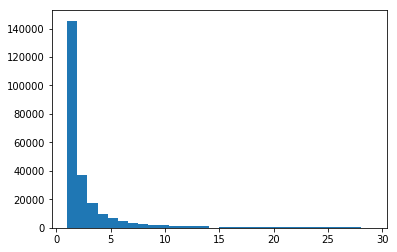

In [81]:
# Check average number of orders per client
print(order_summary['num_orders'].mean())

# Check histogram of number of orders per client
plt.hist(order_summary[order_summary['num_orders'] < 30]['num_orders'], bins=30)
plt.show()

In [82]:
# Set dictionary with model parameters
config = {'batch_size': 128, 'num_epochs': 50, 'input_size': 34, 'seed': 142,
          'gpu_frac': 0.5, 'threshold': 0.5, 'learning_rate': 1e-3, 'num_rnn_layers': 2,
          'hid_size': 64}
config = Bunch(config)

# Create default graph
tf.reset_default_graph()

# Set configuration
gpu_config = set_gpu_config(config.gpu_frac)

# Create session
sess = tf.Session(config=gpu_config)

# Create batch iterators
batch_iterator = BatchIterator(config, order_data_lbl.iloc[:, 1:-1])
iter_dict = {'train': batch_iterator.create_iterator(sess, order_summary_train.iloc[:, 1:], True),
             'val': batch_iterator.create_iterator(sess, order_summary_val.iloc[:, 1:], False)}

# Create model
model = Model(config)

# Create trainer
trainer = Trainer(sess, config, model, iter_dict)

# Train (num_epochs in config dictionary)
trainer.train()

Initial validation nefore training
TRAIN, epoch 0 : accuracy= 0.2261, auc= 0.5000, loss= 1.0871
VAL, epoch 0 : accuracy= 0.2261, auc= 0.5000, loss= 1.0870
Training started


TRAIN, epoch 1 : accuracy= 0.7846, auc= 0.7231, loss= 0.4781
VAL, epoch 1 : accuracy= 0.8009, auc= 0.7491, loss= 0.4557


TRAIN, epoch 2 : accuracy= 0.7979, auc= 0.7429, loss= 0.4602
VAL, epoch 2 : accuracy= 0.8046, auc= 0.7551, loss= 0.4520


TRAIN, epoch 3 : accuracy= 0.8041, auc= 0.7505, loss= 0.4535
VAL, epoch 3 : accuracy= 0.8055, auc= 0.7571, loss= 0.4513


TRAIN, epoch 4 : accuracy= 0.8058, auc= 0.7553, loss= 0.4498
VAL, epoch 4 : accuracy= 0.8061, auc= 0.7586, loss= 0.4499


TRAIN, epoch 5 : accuracy= 0.8051, auc= 0.7562, loss= 0.4495
VAL, epoch 5 : accuracy= 0.8069, auc= 0.7611, loss= 0.4464


TRAIN, epoch 6 : accuracy= 0.8074, auc= 0.7573, loss= 0.4472
VAL, epoch 6 : accuracy= 0.8082, auc= 0.7619, loss= 0.4452


TRAIN, epoch 7 : accuracy= 0.8067, auc= 0.7573, loss= 0.4474
VAL, epoch 7 : accuracy= 0.8076, auc= 0.7615, loss= 0.4458


TRAIN, epoch 8 : accuracy= 0.8076, auc= 0.7578, loss= 0.4469
VAL, epoch 8 : accuracy= 0.8081, auc= 0.7627, loss= 0.4450


TRAIN, epoch 9 : accuracy= 0.8075, auc= 0.7587, loss= 0.4460
VAL, epoch 9 : accuracy= 0.8081, auc= 0.7623, loss= 0.4457


TRAIN, epoch 10 : accuracy= 0.8081, auc= 0.7592, loss= 0.4455
VAL, epoch 10 : accuracy= 0.8078, auc= 0.7627, loss= 0.4456


TRAIN, epoch 11 : accuracy= 0.8081, auc= 0.7599, loss= 0.4450
VAL, epoch 11 : accuracy= 0.8082, auc= 0.7628, loss= 0.4444


TRAIN, epoch 12 : accuracy= 0.8088, auc= 0.7601, loss= 0.4448
VAL, epoch 12 : accuracy= 0.8078, auc= 0.7641, loss= 0.4444


TRAIN, epoch 13 : accuracy= 0.8087, auc= 0.7608, loss= 0.4447
VAL, epoch 13 : accuracy= 0.8095, auc= 0.7639, loss= 0.4445


TRAIN, epoch 14 : accuracy= 0.8084, auc= 0.7617, loss= 0.4442
VAL, epoch 14 : accuracy= 0.8087, auc= 0.7641, loss= 0.4437


TRAIN, epoch 15 : accuracy= 0.8085, auc= 0.7612, loss= 0.4447
VAL, epoch 15 : accuracy= 0.8089, auc= 0.7642, loss= 0.4437


TRAIN, epoch 16 : accuracy= 0.8088, auc= 0.7618, loss= 0.4439
VAL, epoch 16 : accuracy= 0.8093, auc= 0.7648, loss= 0.4449


TRAIN, epoch 17 : accuracy= 0.8088, auc= 0.7626, loss= 0.4439
VAL, epoch 17 : accuracy= 0.8096, auc= 0.7654, loss= 0.4439


TRAIN, epoch 18 : accuracy= 0.8082, auc= 0.7629, loss= 0.4436
VAL, epoch 18 : accuracy= 0.8087, auc= 0.7653, loss= 0.4437


TRAIN, epoch 19 : accuracy= 0.8085, auc= 0.7627, loss= 0.4439
VAL, epoch 19 : accuracy= 0.8088, auc= 0.7650, loss= 0.4433


TRAIN, epoch 20 : accuracy= 0.8094, auc= 0.7637, loss= 0.4432
VAL, epoch 20 : accuracy= 0.8096, auc= 0.7653, loss= 0.4434


TRAIN, epoch 21 : accuracy= 0.8091, auc= 0.7638, loss= 0.4428
VAL, epoch 21 : accuracy= 0.8094, auc= 0.7652, loss= 0.4431


TRAIN, epoch 22 : accuracy= 0.8089, auc= 0.7637, loss= 0.4431
VAL, epoch 22 : accuracy= 0.8095, auc= 0.7649, loss= 0.4434


TRAIN, epoch 23 : accuracy= 0.8091, auc= 0.7637, loss= 0.4433
VAL, epoch 23 : accuracy= 0.8095, auc= 0.7656, loss= 0.4431


TRAIN, epoch 24 : accuracy= 0.8088, auc= 0.7640, loss= 0.4429
VAL, epoch 24 : accuracy= 0.8093, auc= 0.7659, loss= 0.4432


TRAIN, epoch 25 : accuracy= 0.8090, auc= 0.7643, loss= 0.4427
VAL, epoch 25 : accuracy= 0.8090, auc= 0.7650, loss= 0.4438


TRAIN, epoch 26 : accuracy= 0.8086, auc= 0.7642, loss= 0.4432
VAL, epoch 26 : accuracy= 0.8099, auc= 0.7646, loss= 0.4448


TRAIN, epoch 27 : accuracy= 0.8095, auc= 0.7644, loss= 0.4425
VAL, epoch 27 : accuracy= 0.8092, auc= 0.7655, loss= 0.4429


TRAIN, epoch 28 : accuracy= 0.8101, auc= 0.7655, loss= 0.4420
VAL, epoch 28 : accuracy= 0.8096, auc= 0.7656, loss= 0.4432


TRAIN, epoch 29 : accuracy= 0.8090, auc= 0.7648, loss= 0.4427
VAL, epoch 29 : accuracy= 0.8094, auc= 0.7657, loss= 0.4432


TRAIN, epoch 30 : accuracy= 0.8091, auc= 0.7647, loss= 0.4428
VAL, epoch 30 : accuracy= 0.8094, auc= 0.7652, loss= 0.4433


TRAIN, epoch 31 : accuracy= 0.8096, auc= 0.7650, loss= 0.4421
VAL, epoch 31 : accuracy= 0.8078, auc= 0.7648, loss= 0.4449


TRAIN, epoch 32 : accuracy= 0.8086, auc= 0.7649, loss= 0.4428
VAL, epoch 32 : accuracy= 0.8098, auc= 0.7648, loss= 0.4433


TRAIN, epoch 33 : accuracy= 0.8093, auc= 0.7650, loss= 0.4427
VAL, epoch 33 : accuracy= 0.8092, auc= 0.7656, loss= 0.4438


TRAIN, epoch 34 : accuracy= 0.8097, auc= 0.7653, loss= 0.4419
VAL, epoch 34 : accuracy= 0.8099, auc= 0.7643, loss= 0.4435


TRAIN, epoch 35 : accuracy= 0.8097, auc= 0.7655, loss= 0.4421
VAL, epoch 35 : accuracy= 0.8096, auc= 0.7654, loss= 0.4433


TRAIN, epoch 36 : accuracy= 0.8092, auc= 0.7655, loss= 0.4422
VAL, epoch 36 : accuracy= 0.8092, auc= 0.7648, loss= 0.4433


TRAIN, epoch 37 : accuracy= 0.8097, auc= 0.7663, loss= 0.4419
VAL, epoch 37 : accuracy= 0.8094, auc= 0.7650, loss= 0.4430


TRAIN, epoch 38 : accuracy= 0.8089, auc= 0.7658, loss= 0.4421
VAL, epoch 38 : accuracy= 0.8097, auc= 0.7653, loss= 0.4430


TRAIN, epoch 39 : accuracy= 0.8088, auc= 0.7657, loss= 0.4423
VAL, epoch 39 : accuracy= 0.8092, auc= 0.7652, loss= 0.4432


TRAIN, epoch 40 : accuracy= 0.8099, auc= 0.7659, loss= 0.4418
VAL, epoch 40 : accuracy= 0.8093, auc= 0.7652, loss= 0.4436


TRAIN, epoch 41 : accuracy= 0.8093, auc= 0.7662, loss= 0.4420
VAL, epoch 41 : accuracy= 0.8092, auc= 0.7655, loss= 0.4432


TRAIN, epoch 42 : accuracy= 0.8098, auc= 0.7661, loss= 0.4415
VAL, epoch 42 : accuracy= 0.8097, auc= 0.7653, loss= 0.4430


TRAIN, epoch 43 : accuracy= 0.8098, auc= 0.7670, loss= 0.4413
VAL, epoch 43 : accuracy= 0.8096, auc= 0.7644, loss= 0.4437


TRAIN, epoch 44 : accuracy= 0.8093, auc= 0.7663, loss= 0.4416
VAL, epoch 44 : accuracy= 0.8100, auc= 0.7656, loss= 0.4431


TRAIN, epoch 45 : accuracy= 0.8098, auc= 0.7665, loss= 0.4412
VAL, epoch 45 : accuracy= 0.8096, auc= 0.7649, loss= 0.4434


TRAIN, epoch 46 : accuracy= 0.8096, auc= 0.7662, loss= 0.4416
VAL, epoch 46 : accuracy= 0.8096, auc= 0.7654, loss= 0.4433


TRAIN, epoch 47 : accuracy= 0.8093, auc= 0.7660, loss= 0.4419
VAL, epoch 47 : accuracy= 0.8098, auc= 0.7653, loss= 0.4431


TRAIN, epoch 48 : accuracy= 0.8097, auc= 0.7663, loss= 0.4416
VAL, epoch 48 : accuracy= 0.8089, auc= 0.7650, loss= 0.4439


TRAIN, epoch 49 : accuracy= 0.8097, auc= 0.7677, loss= 0.4410
VAL, epoch 49 : accuracy= 0.8097, auc= 0.7653, loss= 0.4432


TRAIN, epoch 50 : accuracy= 0.8094, auc= 0.7669, loss= 0.4416
VAL, epoch 50 : accuracy= 0.8096, auc= 0.7648, loss= 0.4436

Training finished


### Plot epoch metrics

In [83]:
x = np.arange(start=0, stop=config.num_epochs+1)

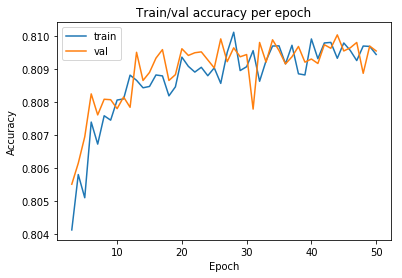

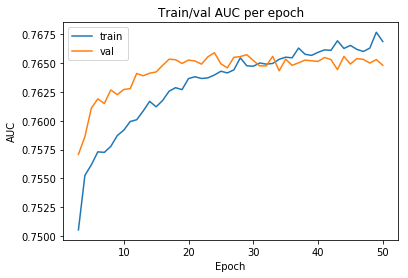

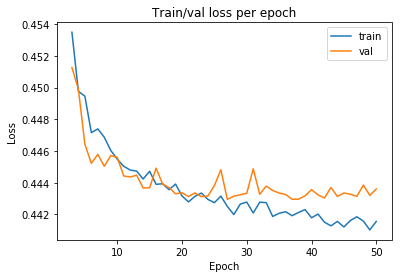

In [85]:
# Accuracy
x1, = plt.plot(x[3:], trainer.train_metrics['acc'][3:])
x2, = plt.plot(x[3:], trainer.val_metrics['acc'][3:])
plt.legend([x1, x2], ['train', 'val'])
plt.title('Train/val accuracy per epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# AUC
x1, = plt.plot(x[3:], trainer.train_metrics['auc'][3:])
x2, = plt.plot(x[3:], trainer.val_metrics['auc'][3:])
plt.legend([x1, x2], ['train', 'val'])
plt.title('Train/val AUC per epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.show()

# Loss
x1, = plt.plot(x[3:], trainer.train_metrics['loss'][3:])
x2, = plt.plot(x[3:], trainer.val_metrics['loss'][3:])
plt.legend([x1, x2], ['train', 'val'])
plt.title('Train/val loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

$Comment:$ The model doesn't show better performance than the other models but still the result is surprisingly not bad. Epoch 28 brings the best metrics on validation set: accuracy= 0.8096, auc= 0.7656, loss= 0.4432.